In [156]:
# from google.colab import drive
# drive.mount('/content/drive')

In [157]:
# path = "/content/drive/MyDrive/Research/cods_comad_plots/sdc_task/mnist/"

In [158]:
m = 2000
desired_num = 100

In [159]:
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from matplotlib import pyplot as plt

import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [160]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [161]:
classes = ('zero','one','two','three','four','five','six','seven','eight','nine')

foreground_classes = {'zero','one'}
fg_used = '01'
fg1, fg2 = 0,1


all_classes = {'zero','one','two','three','four','five','six','seven','eight','nine'}
background_classes = all_classes - foreground_classes
background_classes

{'eight', 'five', 'four', 'nine', 'seven', 'six', 'three', 'two'}

In [162]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle = False)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle = False)

In [163]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(6000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

In [164]:
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img#.numpy()
  plt.imshow(np.reshape(npimg, (28,28)))
  plt.show()

In [165]:
foreground_data.shape, foreground_label.shape, background_data.shape, background_label.shape

(torch.Size([12665, 1, 28, 28]),
 torch.Size([12665]),
 torch.Size([47335, 1, 28, 28]),
 torch.Size([47335]))

In [166]:
val, idx = torch.max(background_data, dim=0, keepdims= True,)
# torch.abs(val)

In [167]:
mean_bg = torch.mean(background_data, dim=0, keepdims= True)
std_bg, _ = torch.max(background_data, dim=0, keepdims= True)

In [168]:
mean_bg.shape, std_bg.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1, 1, 28, 28]))

In [169]:
foreground_data = (foreground_data - mean_bg) / std_bg
background_data = (background_data - mean_bg) / torch.abs(std_bg)

In [170]:
foreground_data.shape, foreground_label.shape, background_data.shape, background_label.shape

(torch.Size([12665, 1, 28, 28]),
 torch.Size([12665]),
 torch.Size([47335, 1, 28, 28]),
 torch.Size([47335]))

In [171]:
torch.sum(torch.isnan(foreground_data)), torch.sum(torch.isnan(background_data))

(tensor(0), tensor(0))

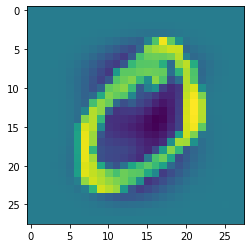

In [172]:
imshow(foreground_data[0])

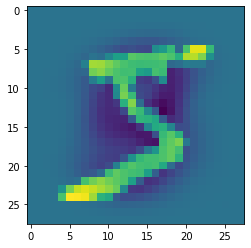

In [173]:
imshow(background_data[0])

## generating CIN train and test data

In [174]:
np.random.seed(0)
bg_idx = np.random.randint(0,47335,m-1)
fg_idx = np.random.randint(0,12665)
bg_idx, fg_idx

(array([ 2732, 43567, 42613, ..., 30745, 34169,  7299]), 884)

In [175]:
# for i in background_data[bg_idx]:
#   imshow(i)

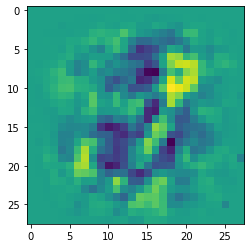

In [176]:
imshow(torch.sum(background_data[bg_idx], axis = 0))

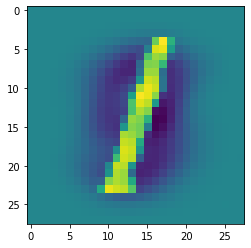

In [177]:
imshow(foreground_data[fg_idx])

In [178]:
tr_data = ( torch.sum(background_data[bg_idx], axis = 0) + foreground_data[fg_idx] )/m
tr_data.shape

torch.Size([1, 28, 28])

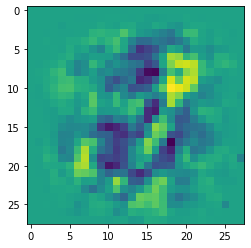

In [179]:
imshow(tr_data)

In [180]:
foreground_label[fg_idx]

tensor(1)

In [181]:
train_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images             
train_label=[]                # label of mosaic image = foreground class present in that mosaic

for i in range(desired_num):
  np.random.seed(i)
  bg_idx = np.random.randint(0,47335,m-1)
  fg_idx = np.random.randint(0,12665)

  tr_data = ( torch.sum(background_data[bg_idx], axis = 0) + foreground_data[fg_idx] ) / m
  label = (foreground_label[fg_idx].item())

  train_images.append(tr_data)
  train_label.append(label)


In [182]:
train_images = torch.stack(train_images)
train_images.shape, len(train_label)

(torch.Size([100, 1, 28, 28]), 100)

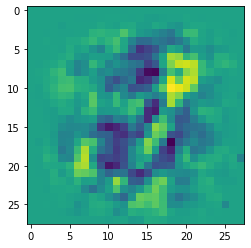

In [183]:
imshow(train_images[0])

In [184]:
test_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images             
test_label=[]                # label of mosaic image = foreground class present in that mosaic

for i in range(10000):
  np.random.seed(i)
  fg_idx = np.random.randint(0,12665)

  tr_data = ( foreground_data[fg_idx] ) / m
  label = (foreground_label[fg_idx].item())

  test_images.append(tr_data)
  test_label.append(label)


In [185]:
test_images = torch.stack(test_images)
test_images.shape, len(test_label)

(torch.Size([10000, 1, 28, 28]), 10000)

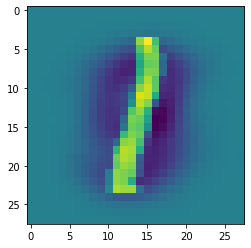

In [186]:
imshow(test_images[0])

In [187]:
torch.sum(torch.isnan(train_images)), torch.sum(torch.isnan(test_images))

(tensor(0), tensor(0))

In [188]:
np.unique(train_label), np.unique(test_label)

(array([0, 1]), array([0, 1]))

## creating dataloader

In [189]:
class CIN_Dataset(Dataset):
  """CIN_Dataset dataset."""

  def __init__(self, list_of_images, labels):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.image = list_of_images
    self.label = labels

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.image[idx] , self.label[idx]



In [190]:
batch = 250
train_data = CIN_Dataset(train_images, train_label)
train_loader = DataLoader( train_data, batch_size= batch , shuffle=True)

test_data = CIN_Dataset( test_images , test_label)
test_loader = DataLoader( test_data, batch_size= batch , shuffle=False)

In [191]:
train_loader.dataset.image.shape, test_loader.dataset.image.shape

(torch.Size([100, 1, 28, 28]), torch.Size([10000, 1, 28, 28]))

## model

In [192]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.fc1 = nn.Linear(28*28, 50)
    self.fc2 = nn.Linear(50, 2)
    
    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)

    torch.nn.init.xavier_normal_(self.fc2.weight)
    torch.nn.init.zeros_(self.fc2.bias)


  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

## training

In [209]:
torch.manual_seed(12)
classify = Classification().double()
classify = classify.to("cuda")

In [210]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer_classify = optim.Adam(classify.parameters(), lr=0.001  ) #, momentum=0.9)

In [211]:
correct = 0
total = 0
count = 0
flag = 1

with torch.no_grad():
  for data in train_loader:
    inputs, labels = data
    inputs = inputs.double()
    inputs, labels  = inputs.to("cuda"),labels.to("cuda")

    outputs = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d train images: %f %%' % ( desired_num , 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 100 train images: 46.000000 %
total correct 46
total train set images 100


In [212]:
correct = 0
total = 0
count = 0
flag = 1

with torch.no_grad():
  for data in test_loader:
    inputs, labels = data
    inputs = inputs.double()
    inputs, labels  = inputs.to("cuda"),labels.to("cuda")

    outputs = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d test images: %f %%' % ( 10000 , 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 10000 test images: 56.400000 %
total correct 5640
total train set images 10000


In [213]:
nos_epochs = 200
tr_loss = []
for epoch in range(nos_epochs):  # loop over the dataset multiple times

  epoch_loss = []
  cnt=0
  iteration = desired_num // batch
  running_loss = 0
  
  #training data set  
  for i, data in  enumerate(train_loader):
    inputs, labels = data
    inputs = inputs.double()
    inputs, labels  = inputs.to("cuda"),labels.to("cuda")
    inputs = inputs.double()
    # zero the parameter gradients
    
    optimizer_classify.zero_grad()

    outputs = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion(outputs, labels) 
    loss.backward()

    optimizer_classify.step()

    running_loss += loss.item()
    mini = 1
    if cnt % mini == mini-1:    # print every 40 mini-batches
      # print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1

  tr_loss.append(np.mean(epoch_loss))
  if(np.mean(epoch_loss) <= 0.001):
      break;
  else:
    print('[Epoch : %d] loss: %.3f' %(epoch + 1, np.mean(epoch_loss) ))
    
print('Finished Training')

[Epoch : 1] loss: 0.695
[Epoch : 2] loss: 0.692
[Epoch : 3] loss: 0.689
[Epoch : 4] loss: 0.686
[Epoch : 5] loss: 0.683
[Epoch : 6] loss: 0.681
[Epoch : 7] loss: 0.679
[Epoch : 8] loss: 0.676
[Epoch : 9] loss: 0.673
[Epoch : 10] loss: 0.671
[Epoch : 11] loss: 0.668
[Epoch : 12] loss: 0.666
[Epoch : 13] loss: 0.663
[Epoch : 14] loss: 0.660
[Epoch : 15] loss: 0.658
[Epoch : 16] loss: 0.655
[Epoch : 17] loss: 0.652
[Epoch : 18] loss: 0.649
[Epoch : 19] loss: 0.647
[Epoch : 20] loss: 0.644
[Epoch : 21] loss: 0.641
[Epoch : 22] loss: 0.638
[Epoch : 23] loss: 0.635
[Epoch : 24] loss: 0.632
[Epoch : 25] loss: 0.629
[Epoch : 26] loss: 0.626
[Epoch : 27] loss: 0.623
[Epoch : 28] loss: 0.620
[Epoch : 29] loss: 0.617
[Epoch : 30] loss: 0.613
[Epoch : 31] loss: 0.610
[Epoch : 32] loss: 0.607
[Epoch : 33] loss: 0.604
[Epoch : 34] loss: 0.601
[Epoch : 35] loss: 0.597
[Epoch : 36] loss: 0.594
[Epoch : 37] loss: 0.591
[Epoch : 38] loss: 0.587
[Epoch : 39] loss: 0.584
[Epoch : 40] loss: 0.581
[Epoch : 

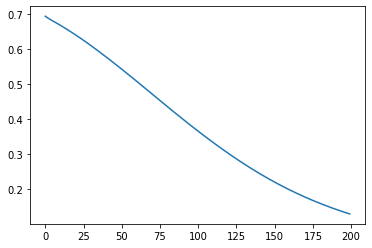

In [214]:
plt.plot(tr_loss)

In [215]:
correct = 0
total = 0
count = 0
flag = 1

with torch.no_grad():
  for data in train_loader:
    inputs, labels = data
    inputs = inputs.double()
    inputs, labels  = inputs.to("cuda"),labels.to("cuda")

    outputs = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d train images: %f %%' % ( desired_num , 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 100 train images: 100.000000 %
total correct 100
total train set images 100


In [216]:
correct = 0
total = 0
count = 0
flag = 1

with torch.no_grad():
  for data in test_loader:
    inputs, labels = data
    inputs = inputs.double()
    inputs, labels  = inputs.to("cuda"),labels.to("cuda")

    outputs = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the %d train images: %f %%' % ( 10000 , 100 * correct / total))
print("total correct", correct)
print("total test set images", total)

Accuracy of the network on the 10000 train images: 46.720000 %
total correct 4672
total test set images 10000
